# Plain vs. Parallel Deep Decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL
import glob

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    torch.cuda.set_device(0)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


In [2]:
def myimgshow(plt,img,plot_size=(4,4)):
    plt.gray()
    plt.rcParams["figure.figsize"] = plot_size
    plt.imshow(np.clip(img[0],0,1),interpolation='nearest')

In [3]:
def load_data(path,img_name=None,black_list=[]):
    # path: directory of images
    # img_name: a specific image
    # black_list: images that are not desired for processing
    
    if img_name is None:
        img_np_list = []
        for filename in glob.glob(path+"/*"):
            if filename not in black_list:
                img=Image.open(filename)
                img_np_list.append(img)
        img_var_list = []
        for i,img in enumerate(img_np_list):
            img_np_list[i] = np.array([pil_to_np(img)[0]])
            img_np_list[i] = img_np_list[i] / np.max(img_np_list[i])
            img_var_list.append(np_to_var(img_np_list[i]).type(dtype))
        return img_np_list,img_var_list
    else:
        img_path = path + "/" + img_name
        img_pil = Image.open(img_path)
        img_np = np.array([pil_to_np(img_pil)[0]])
        img_np = img_np / np.max(img_np)
        img_var = np_to_var(img_np).type(dtype)
        return img_np,img_var

## Load image(s)

In [4]:
path = "./test_data"
img_name = "brain_sagittal.jpg"
#ps = ".jpg"
single_image = False # this flag determines whether the analysis is needed for one image or a group of images

In [5]:
img_np_list,img_var_list = load_data(path,black_list=[path+"/"+img_name])
img_np,img_var = load_data(path,img_name)

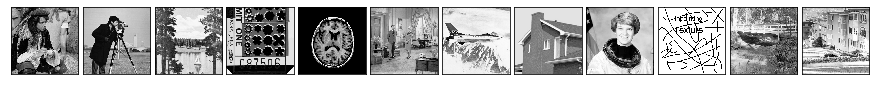

In [6]:
if single_image:
    myimgshow(plt,img_np)
    plt.axis("off")
    plt.show()
else:
    plot_image_grid([img[0] for img in img_np_list],nrows=1)
    plt.show()    

In [7]:
if single_image:
    data_np = [img_np]
    data_var = [img_var]
else:
    data_np = img_np_list
    data_var = img_var_list

## Define network ant train it

In [22]:
output_depth = [img.shape[0] for img in data_np]
num_channels0 = 139
num_channels = 90
num_layers = 6
decoders_numlayers_list = [2,4,6] # #layers for each decoding block in the parallel architecture
decoders_last_channels = [num_channels]*3
maxv = [np.max(img) for img in data_np]
in_size = [32,32]
out_size = [img[0].shape for img in data_np]

rnd = 500
numit = 20000
rn = 0.001
LR = 0.01

par_psnr = np.zeros(len(data_np))
plain_psnr = np.zeros(len(data_np))

for i,img in enumerate(data_var):
    
    parnet = pardecoder(out_size[i],in_size,num_output_channels = output_depth[i],
                     num_channels=num_channels,
                     decoders_numlayers_list = decoders_numlayers_list,
                     decoders_last_channels = decoders_last_channels).type(dtype)
    
    plainnet = skipdecoder(out_size[i],in_size,output_depth[i],num_layers,num_channels0,skips=False).type(dtype)
    
    bold = '\033[1m'
    end = '\033[0m'
    print(bold + "image {}:".format(i) + end)
    
    print("#parallel_net parameters:",num_param(parnet))
    print("#plain_net parameters:",num_param(plainnet))
    print("train parallel") 
    mse_n, mse_t, parni, parnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(decoders_numlayers_list[-1]-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=LR,
                            img_noisy_var=img,
                            net=parnet,
                            img_clean_var=img,
                            find_best=True,
                            )
    out_img_np = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
    par_psnr[i] = psnr(data_np[i],out_img_np,maxv[i])
    print("\n")
    
    print("train plain")    
    mse_n, mse_t, plainni, plainnet = fit( in_size = in_size,
                            num_channels=[num_channels0]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=LR,
                            img_noisy_var=img,
                            net=plainnet,
                            img_clean_var=img,
                            find_best=True,
                            #orth_reg=0.1,
                            )    
    out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
    plain_psnr[i] = psnr(data_np[i],out_img_np,maxv[i])
    print("\n"*2)

print("average parallel_net psnr:",par_psnr.mean())
print("average plain_net psnr:",plain_psnr.mean())

image 0:
#parallel_net parameters: 99090
#plain_net parameters: 98134
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000199  Actual loss 0.000199 Actual loss orig 0.000199  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000309  Actual loss 0.000309 Actual loss orig 0.000309  Noise Energy 0.000000                             


image 1:
#parallel_net parameters: 99090
#plain_net parameters: 98134
train parallel
shape:  [1, 90, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000035  Actual loss 0.000035 Actual loss orig 0.000035  Noise Energy 0.000000 

train plain
shape:  [1, 139, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000086  Actual loss 0.000086 Actual loss orig 0.000086  Noise Energy 0.000000                  


image 2:
#parallel_net parameters: 99090
#plain_net parameters: 98134
train parallel
shape:  [1, 90, 32, 32]
optimize

In [23]:
print("parallel psnr:",par_psnr,"\n")
print("plain psnr:",plain_psnr)

parallel psnr: [36.92540879 45.59290246 35.28278479 39.06603805 46.48422668 36.7274674
 40.68027326 50.15789538 43.69147507 38.60437606 31.67667485 32.1062368 ] 

plain psnr: [35.17926921 44.25597013 34.81343549 38.71757846 41.42362138 34.91184646
 40.01574252 50.13860821 41.69448727 36.60873946 30.40039609 30.39595861]


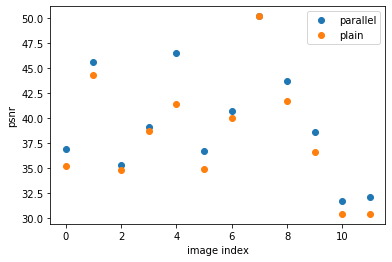

In [24]:
plt.plot(par_psnr,"o",label="parallel")
plt.plot(plain_psnr,"o",label="plain")
plt.xlabel("image index")
plt.ylabel("psnr")
plt.legend()
plt.show()

### Visualize Skipnet Activations and Output for the Last Image

##### skip deep decoder representation for the input image

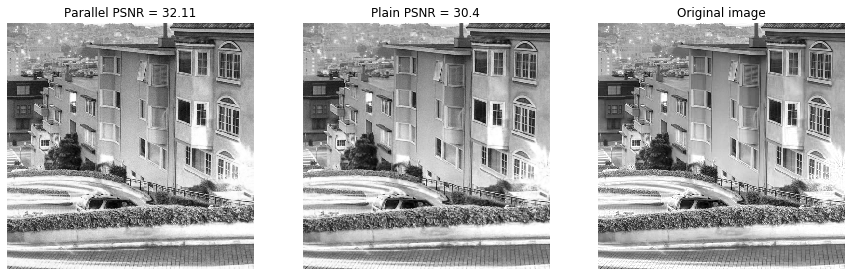

In [26]:
plot_size = (15,15)

### plot parallel output
out_img_np = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
maxv = np.max(data_np[-1])
plt.subplot(131)
myimgshow(plt,out_img_np,plot_size = plot_size)
plt.title("Parallel PSNR = {}".format( round(psnr(data_np[-1],out_img_np,maxv),2) ))
plt.axis('off')

### plot plain output
out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
plt.subplot(132)
myimgshow(plt,out_img_np,plot_size = plot_size)
plt.title("Plain PSNR = {}".format( round(psnr(data_np[-1],out_img_np,maxv),2) ))
plt.axis('off')

### plot origial image
plt.subplot(133)
myimgshow(plt,data_np[-1],plot_size = plot_size)
plt.axis('off')
plt.title("Original image")
#plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()

In [24]:
def plot_tensor(out,nrows=8):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

##### individual channels per layer

first decoder


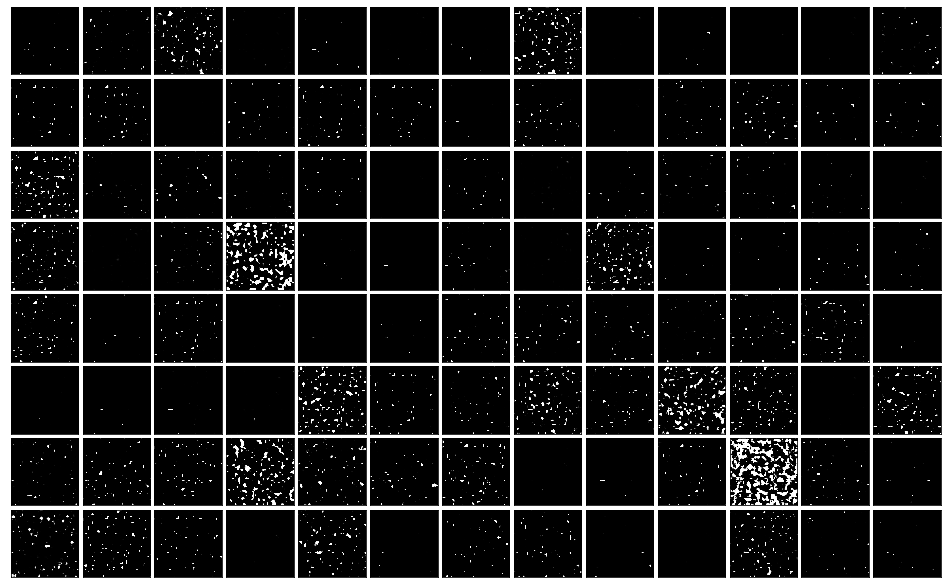

second decoder


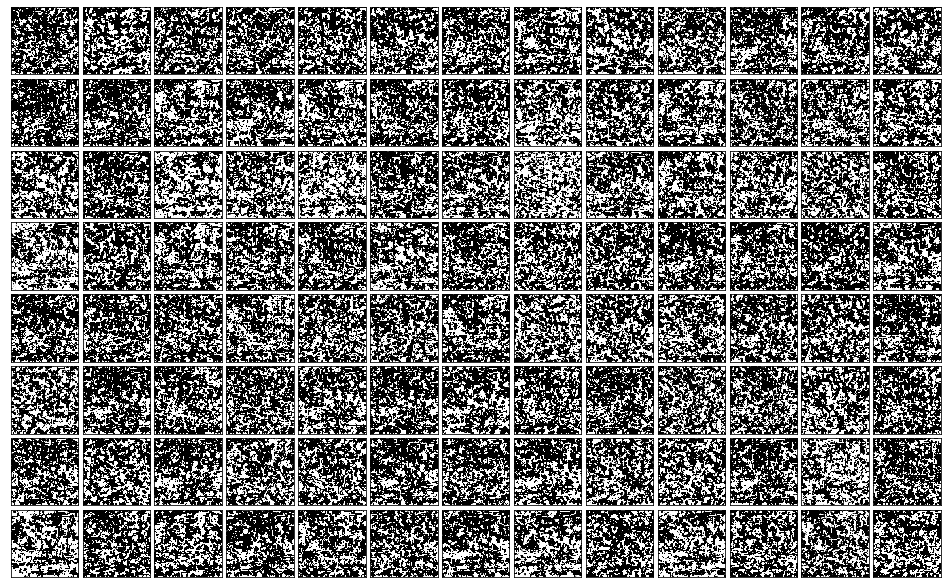

third decoder


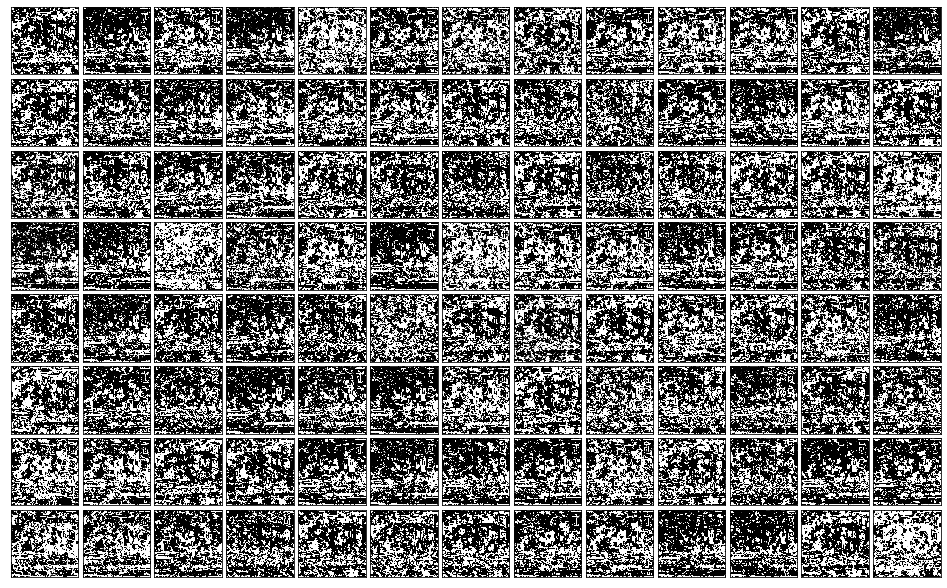

In [25]:
print("first decoder")
out1 = parnet.net1(parni.type(dtype))
plot_tensor(out1)

print("second decoder")
out2 = parnet.net2(parni.type(dtype))
plot_tensor(out2)

print("third decoder")
out3 = parnet.net3(parni.type(dtype))
plot_tensor(out3)

##### mean over channels per layer

first decoder


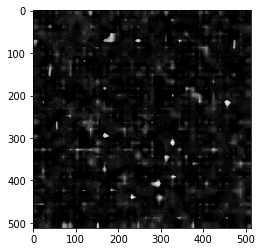

second decoder


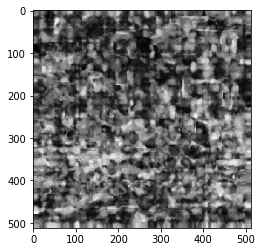

third decoder


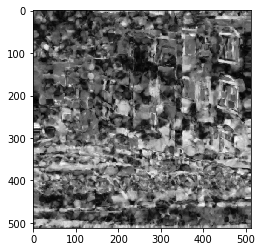

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
print("first decoder")
plt.imshow(out1.mean(1)[0].data.cpu())
plt.show()

print("second decoder")
plt.imshow(out2.mean(1)[0].data.cpu())
plt.show()

print("third decoder")
plt.imshow(out3.mean(1)[0].data.cpu())
plt.show()

# Draft

In [35]:
def apply_until(net_input,net,n = 100):
    # gets intermediate outputs from the network
    if n == 0:
        return net_input
    else:
        print("output up to block{}: {}".format(n,net[n-1]))
        return net[:n](net_input.type(dtype))

def plot_tensor(out,nrows=1):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

### simple test

##### generate a random image

shape:  [1, 1, 16, 16]


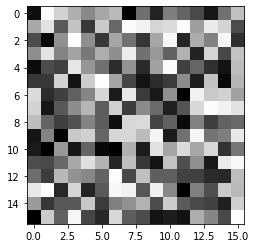

In [38]:
in_size = [4,4] # size of network input
num_channels = 4 # number of input channels (and also number of channels per layer)
out_size = [16,16] # size of original image
output_depth = 1 # number of channels in the original image

width = out_size[0]
height = out_size[1]
shape = [1,output_depth, width, height]
print("shape: ", shape)
img_var = Variable(torch.zeros(shape))
img_var.data.uniform_()
img_var.data *= 1./10
img_var = img_var.type(dtype)

myimgshow(plt,img_var[0].cpu())

##### create a parallel network

In [39]:
decoders_numlayers_list = [2,3,4] # #layers for each decoding block
decoders_last_channels = [4,4,4]
net = pardecoder(out_size,in_size,num_output_channels = output_depth,
                 num_channels=num_channels,
                 decoders_numlayers_list = decoders_numlayers_list,
                 decoders_last_channels = decoders_last_channels).type(dtype)
num_param(net)

204

In [40]:
parnet

cat_model(
  (net1): Sequential(
    (1): Conv2d(104, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Upsample(size=(512, 512), mode=bilinear)
    (3): ReLU()
    (4): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(104, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
  (net2): Sequential(
    (1): Conv2d(104, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Upsample(size=(81, 81), mode=bilinear)
    (3): ReLU()
    (4): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(104, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): Upsample(size=(204, 204), mode=bilinear)
    (7): ReLU()
    (8): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(104, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (10): Upsample(size=(512, 512), mode=bilinear)
    (11): ReLU()
    (12): BatchNorm2d(1

##### fit the parnet to the original image

In [41]:
rnd = 500
numit = 5000
rn = 0.001
mse_n, mse_t, ni, net = fit( in_size=in_size,
                        num_channels=[num_channels]*(max(decoders_numlayers_list)-1),
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.01,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=True,
                        #orth_reg=0.1,
                        )
out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]

shape:  [1, 4, 4, 4]
optimize with adam 0.01


##### individual channels per layer (before and after upsampling)

first decoder


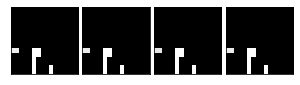

second decoder


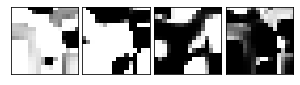

third decoder


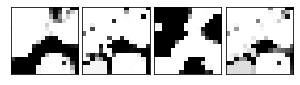

In [42]:
print("first decoder")
out1 = net.net1(ni.type(dtype))
plot_tensor(out1)

print("second decoder")
out2 = net.net2(ni.type(dtype))
plot_tensor(out2)

print("third decoder")
out3 = net.net3(ni.type(dtype))
plot_tensor(out3)

##### skipnet representation ofthe image

Skip-Deep-Decoder representation of the image, SNR: 13.50753659949474


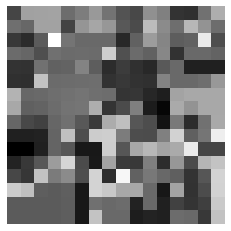

In [43]:
maxv = np.max(np.array(img_var[0].cpu()))
print("Skip-Deep-Decoder representation of the image, SNR: " + str(psnr(img_var[0].data.cpu().numpy(),out_img_np,maxv)))
myimgshow(plt,out_img_np)
plt.axis('off')
plt.show()

##### original image

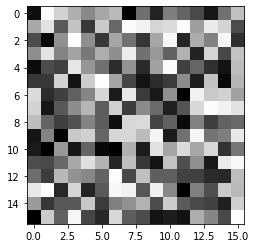

In [44]:
myimgshow(plt,img_var[0].cpu())